## Snap Facebook graph data 

### Untarring the tar file (Do this just once!)

This only needs to be done the first time you use this notebook, to extract the files from the archive downloaded from snap.

In [1]:
import tarfile
import os.path

def py_files(members,extension):
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == extension:
            yield tarinfo

# If you get an IO error it's because you havent placed the 
# facebook tar file in the facebook_ego_network directory relative
# to the notebook.  Edit the path to be right create the directory
# and move the tarfile there.
tar_file_path = os.path.join('facebook_ego_network',"facebook.tar.gz")
tar = tarfile.open(tar_file_path)
# To untar just one type of file
#tar.extractall(members=py_files(tar,extension=".edges"))
tar.extractall()
tar.close()

###  Reading in the edges of an ego network

Starting here, we have cells that need to be re-executed each time you run the notebook, first to build the graph of ego's friends, or the ego network.

In [2]:
import networkx as nx
import os.path

# The tarfile You need to 
facebook_dir = os.path.join('facebook_ego_network', 'facebook')

# Read in edges of graph, treating node id as ints (otherwise they'd be strings)
# Change the value of egoid to look at a different ego.  There are 10 ego graphs
# in the data set.
egoid = 0

G = nx.read_edgelist(os.path.join(facebook_dir,f'{egoid}.edges'),nodetype=int)


This particular egoid has 333 friends.  Note that there is never a node for ego in this graph.  If there were, ego would just be a node connected to all the others.

In [2]:
len(G.nodes())

333

### Adding data about ego and nodes

Each feature index in the SNAP feature system represents a feature,value pair.
 For example, the feature index 24 might represent the value `'Harvard'` for
the feature `'education;school'`.  For each node, the feature is either on
 or off.  In the ego graph for ego_id 0, Features 24-52 all represent 
 possible values for the 'education;school' feature. For most individuals 
 only one of the features in that range will be on. We're using numbers so we 
 don't know which feature values represent which actual schools. Similarly 
 features 77 and 78 represent the two values for the gender feature, but we don't 
 know which represents male and which female. Using integers **anonymizes** the 
feature values, so we can't use the cluster of features
belonging to an individual in a network to identify them.

In [3]:

from collections import defaultdict

def read_featnames_file (ego_id):
    """
    Return a Decoding list and a feature dict. The decoding list maps 
    from a SNAP feature id to a feature name. feat_dict[i] is the feature name 
    for which feature code `i`  defines a value. So `feat_dict[77]` and 
    `decoding_list[78]` both are 'gender`.  The keys of `feat_dict` are feature names. 
    For each feature name, `feat_dict[i]` gives the the list of features that 
    represent values for that feature,
    so for the ego network for egoid 0, feature_dict['gender'] is [77,78].
    """
    global decoding_dict,feat_dict,feats0,facebook_dir
    
    with open(os.path.join(facebook_dir, f'{ego_id:d}.featnames')) as fh:
        feats = fh.readlines()
    decoding_list,feat_dict = [],defaultdict(list)
    feats0 = [l.strip().split() for l in feats]
    decoding_list =  [';'.join(featname.split(';')[:-1])
                      for (local_index,featname,_,global_index) in feats0]
    for (index,featname) in enumerate(decoding_list):
        feat_dict[featname].append(index)
    return (decoding_list, feat_dict)

egoid = 0
# decoding_list feat_index -> feat_name
# feat_dict feat_name -> feat_index
(decoding_list,feat_dict) = read_featnames_file(egoid)
    
    
    

If you want to know the meaning of feature 10, you look it up in the decoding list:

In [4]:
print(decoding_list[10])
decoding_list[8:20]

education;classes;id


['education;classes;id',
 'education;classes;id',
 'education;classes;id',
 'education;classes;id',
 'education;classes;id',
 'education;concentration;id',
 'education;concentration;id',
 'education;concentration;id',
 'education;concentration;id',
 'education;concentration;id',
 'education;concentration;id',
 'education;concentration;id']

`education;concentration;id` occurs once for each possible value of the
`education;conecentration` feature.

So the total number of feature values (combining values from all features)
is:

In [5]:
len(decoding_list)

224

Over 200 feature values were found. The values are there 
because some user decided to include a 
particular kind of information (such as high school attended) in their profile.
Bear in mind that many Facebook users provide very little information about themselves,
so that most features have no value for most users.  For example, the graph for egoid 0
includes several individuals about whom we know nothing but their gender.

How many distinct features are there? What are they and how many values does each have?

In [4]:
from collections import Counter
value_ctr = Counter(decoding_list)
print ('There are {0} features'.format(len(feat_dict)))
print()
ctr = 0
for k,v in sorted(feat_dict.items()):
    print(f"{k+':':27s}  {value_ctr[k]:>2d} values")
    ctr += len(v)

print('-' * 45)
width = 5 + max(len(f) for f in feat_dict.keys())
print(f'{ctr:>{width}} values')

There are 21 features

birthday:                     8 values
education;classes;id:         5 values
education;concentration;id:   7 values
education;degree;id:          4 values
education;school;id:         29 values
education;type:               3 values
education;with;id:            1 values
education;year;id:           16 values
first_name:                   4 values
gender:                       2 values
hometown;id:                 11 values
languages;id:                14 values
last_name:                   21 values
locale:                       3 values
location;id:                 12 values
work;employer;id:            20 values
work;end_date:               16 values
work;location;id:            12 values
work;position;id:            13 values
work;start_date:             22 values
work;with;id:                 1 values
---------------------------------------------
                            224 values


In [5]:
def add_node_properties_to_graph(G,ego_id,decoding_list):
    global featlist, facebook_dir
    with open(os.path.join(facebook_dir, f'{ego_id:d}.feat')) as fh:
        featlist = [[int(x) for x in line.strip().split()] for line in fh.readlines()]
    nodelist = G.nodes()
    for atts in featlist:
        node,feats = atts[0],atts[1:]
        #print len(feats)
        if node in nodelist:
            pass
        else:
            # For notification of the addition of unconnected nodes
            # print(f'Adding {node}')
            G.add_node(node,attr_dict = {})
        add_feats_to_feat_dict(feats, G.nodes()[node], decoding_list)

def add_feats_to_feat_dict (feats, feat_dict, decoding_list):
    """
    We do not assume features are single-valued; i.e., each person has only one
    highest degree, one school attended, one gender.  
    
    For example the feature `languages` may have multiple vals.
    """
    for (feat_index,val) in enumerate(feats):
        feat = decoding_list[feat_index]
        if val:
            if feat in feat_dict and feat_index not in feat_dict[feat]:
                feat_dict[feat] += (feat_index,)
            else:
                feat_dict[feat] = (feat_index,)
  
    
def read_ego_features(ego_id, decoding_list):
    """
    Return a feat dict for ego just like the feat_dicts found in G.node,
    except this one won't belong to a node in the graph.  Useful for comparing
    features of ego to features of ego's friends.
    """
    with open(os.path.join(facebook_dir,f'{ego_id:d}.egofeat')) as fh:
        featlist = [int(x) for x in fh.readline().strip().split()]
    ego_feat_dict = {}
    add_feats_to_feat_dict(featlist, ego_feat_dict, decoding_list)
    return ego_feat_dict

def add_circles_to_graph(G,ego_id,decoding_list):
    with open(os.path.join(facebook_dir,f'{ego_id:d}.circles')) as fh:
         circlelist0 = [line.strip().split() for line in fh.readlines()]
    #circles = [circ[0] for circ in circlelist]
    print (f'{len(circlelist0)} circles found!')
    # We treat the n circles found as the n possible values for a new feature named circles
    for i in range(len(circlelist0)):
        decoding_list.append('circles')
    circlelist = [[int(ind) for ind in circ[1:]] for circ in circlelist0]
    for (circid,members) in enumerate(circlelist):
        for m in members:
            node_dict = G.nodes()[m]
            if 'circles' not in node_dict:
                # Because we want to do set based comparison 
                # of circles, we want tuples
                node_dict['circles'] = (circid,)
            elif circid not in node_dict['circles']:
                node_dict['circles'] += (circid,)
    return circlelist
    

Execute the cell above before executing the cell below.  Click on the cell below and Type `Esc-l` to toggle line numbers if they aren't already there.

In [6]:
egoid = 0
add_node_properties_to_graph(G,egoid,decoding_list) 
circlelist = add_circles_to_graph(G,egoid,decoding_list)
ego_feat_dict = read_ego_features(egoid, decoding_list)

24 circles found!


In line 1 we decide on the ego id whose ego graph we are analyzing. In  line 2 we add the known properities of the friends in that graph and store them on the graph (see below).  In line 3 we compute the circles
and return them in a list.  Each circle is a list of ego's friends, so `circlelist` is a list of lists.  For example there might be one circle for family members, another for work, another for karate club members, and so on. Finally in line 5 we compute the properties ego has made public on his/her profile page and store them in a dictionary.

Friend properties have been stored as dictionaries we'll call **feat_dicts**.  The feat dicts of all ego's friends are stored in one big dictionary keyed by node names in `G.node`. Ego is not part of the graph, nor is ego's feat dict.  It's just a separate feat dict that we computed in line 4 in the cell above. 

Here are ego's features.

In [7]:
ego_feat_dict

{'education;classes;id': (9,),
 'education;concentration;id': (14,),
 'education;school;id': (39, 50, 52),
 'education;type': (53, 54, 55),
 'education;year;id': (69,),
 'gender': (78,),
 'last_name': (104,),
 'locale': (127,),
 'location;id': (129,),
 'work;employer;id': (145, 147, 151, 156),
 'work;end_date': (160, 163, 166, 168),
 'work;location;id': (176,),
 'work;position;id': (192, 195),
 'work;start_date': (205, 206, 208, 210, 212, 219)}

Here's a sample of the kinds of features found among ego's friends. Remember all ego's friends
will be identified by an id number, a unique integer.

G.nodes is both callable (returns a node sequence) and dictionary-like
(node_name -> attribute dictionary).

In [8]:
G.nodes[236]

{'birthday': (7,),
 'education;concentration;id': (14,),
 'education;school;id': (50,),
 'education;type': (53,),
 'education;year;id': (59,),
 'gender': (77,),
 'locale': (127,),
 'location;id': (138,),
 'work;employer;id': (149, 152),
 'work;end_date': (160, 169, 173, 175),
 'work;location;id': (182, 185),
 'work;position;id': (195,),
 'work;start_date': (210, 216, 219, 220, 222),
 'circles': (4, 15)}

#### Does anyone belong to more than one circle?

In [9]:
from collections import Counter

ctr = Counter()

for friend in G.nodes():
    feat_dict = G.nodes[friend]
    if 'circles' in feat_dict and len(feat_dict['circles']) > 1:
        #print(f"{friend:>4}: ",end=" ")
        #for circ in feat_dict['circles']:
        #    print(f'{circ:>2}',end=' ')
        #print()
        ctr[feat_dict['circles']]  += 1

ctr_pairs = ctr.most_common()

#print('_'*12)
print(f"+{('='*10)}+")
for ((circ1,circ2), ct) in ctr_pairs:
    print(f'|{circ1:>2} {circ2:>2} | {ct:>2}|')
print(f"+{('='*10)}+")
#print(f"|{('_'*10)}|")

print()
print('Selected Circle Sizes')
print('='*len('Selected Circle Sizes'))
for (c,ct) in [(c,len(circlelist[c])) for c in [6,9,10,15]]:
    print(f'      {c:>2} {ct:>3}')

+==========+
| 6 19 | 10|
|15 16 |  9|
| 4 15 |  6|
|15 17 |  3|
| 0 11 |  3|
| 5 15 |  1|
|11 15 |  1|
| 9 15 |  1|
| 4 16 |  1|
| 1 16 |  1|
| 8 20 |  1|
| 0 15 |  1|
| 6 17 |  1|
+==========+

Selected Circle Sizes
       6  20
       9  10
      10   4
      15 133


So a large number of ego's friends belong to more than one of ego's circles, and
there are certain circles, like 6 and 19, that have a large amount of 
membership overlap, as well as certain circles, like 15, the very 
large circle, that have overlaps with a number of others.  

#### How many of ego's friends have the same last name as ego?

In [10]:
node_info = G.nodes(data=True)
node_info[236]

{'birthday': (7,),
 'education;concentration;id': (14,),
 'education;school;id': (50,),
 'education;type': (53,),
 'education;year;id': (59,),
 'gender': (77,),
 'locale': (127,),
 'location;id': (138,),
 'work;employer;id': (149, 152),
 'work;end_date': (160, 169, 173, 175),
 'work;location;id': (182, 185),
 'work;position;id': (195,),
 'work;start_date': (210, 216, 219, 220, 222),
 'circles': (4, 15)}

In [13]:
node_info = G.nodes(data=True)
ego_last = ego_feat_dict['last_name']
sum(1 for friend,nd in node_info
     if 'last_name' in nd and nd['last_name'] == ego_last)

5

#### What circle has the most people with the same last name as ego?  

Perhaps this is a family circle?

In [11]:
from collections import Counter
shared_last = Counter()
ego_last = ego_feat_dict['last_name']
node_info_dict = G.nodes

# Loop through all the circles
for (i,c) in enumerate(circlelist):
    # loop through the members of a given circle
    for m in c:
        m_info = node_info_dict[m]
        # If this member has revealed his last name and 
        # it is the same as ego's
        if 'last_name' in m_info and \
            m_info['last_name'] == ego_last:
                # increment the count of how many last name sharers
                # there are in this circle
                shared_last[i] += 1

#What are top three circles as far as sharing last names with ego goes?
shared_last.most_common(3)            
    

[(14, 2), (7, 1), (12, 1)]

One circle, circle 14, has two members with the same last name as ego.  How many members does circle 14 have?

In [15]:
len(circlelist[14])

2

## Similarity of friends: Homophily

We speculated above that the two members of Circle 14 might be related to ego, because they have the same last name.

Let's try to **measure** how similar these two friends are, as well as how similar they are to ego.

We'll use a very famous similarity function known as the **Dice coefficient**, after its inventor, Lee Dice, who introduced it in the following work:

> Dice, Lee R. "Measures of the amount of ecologic association between species." Ecology 26.3 (1945): 297-302.

The Dice coefficient counts the number of shared properties two entities `a` and `b`
have, and divides by the size of the set of their combined properties. That is, what proportion of the combined properties of `a` and `b` are shared?

To facilitate  comparison with ego's properties, we define it as a function of feature_dicts.

In [12]:
def hashable(item):
    try:
      hash(item)
      return True
    except TypeError as e:
      return False

def items2tuple(items):
    return tuple(filter(hashable,items))

def dice_coefficient (fd1,fd2):
    """
    Returns a number between 0 and 1 representing the similarity of
    feature set `fd1` to feature set `fd2`, which are dictionaries
    with hashable values (strings, ints, or tuples, no lists).
    """
    fd1_s,fd2_s = set(items2tuple(fd1.items())),\
                  set(items2tuple(fd2.items()))
    
    return len(fd1_s.intersection(fd2_s))/len(fd1_s.union(fd2_s))

node_info_dict = G.nodes

# The two members of circle 14
mem1, mem2 = circlelist[14][0],circlelist[14][1]
# The feat dicts of those two members, taken from the graph.
mem1_feat_dict, mem2_feat_dict = node_info_dict[mem1], node_info_dict[mem2]

# The similarities of 3 pairs of individuals
mems12_sim = dice_coefficient(mem1_feat_dict, mem2_feat_dict)
mem1_ego_sim = dice_coefficient(mem1_feat_dict, ego_feat_dict)
mem2_ego_sim = dice_coefficient(mem2_feat_dict, ego_feat_dict)

print(f"Sim({mem1}, {mem2}): {mems12_sim:.2f}")
print(f"Sim({mem1}, ego): {mem1_ego_sim:.2f}")
print(f"Sim({mem2}, ego): {mem2_ego_sim:.2f}")

Sim(175, 227): 0.31
Sim(175, ego): 0.15
Sim(227, ego): 0.08


In [17]:
mem1_feat_dict

{'birthday': (4,),
 'education;school;id': (45,),
 'education;type': (55,),
 'gender': (78,),
 'hometown;id': (88,),
 'last_name': (104,),
 'locale': (127,),
 'location;id': (137,),
 'circles': (14,)}

In [119]:
mem2_feat_dict

{'birthday': (7,),
 'education;school;id': (26, 45),
 'education;type': (53, 55),
 'education;year;id': (65, 69),
 'gender': (77,),
 'hometown;id': (88,),
 'last_name': (104,),
 'locale': (127,),
 'location;id': (137,),
 'work;location;id': (177,),
 'work;start_date': (215,),
 'circles': (14,)}

## Highest degree centrality

This is a lot like things we've done before.  Let's write a function which given a scoring dictionary, turns it into a list and sorts it highest scorer to lowest scorer:

In [13]:
import networkx as nx

def sort_score_dict (score_dict):
    return sorted(score_dict.items(),key=lambda x:x[1],reverse=True)

degree_list = sort_score_dict(nx.degree_centrality(G))

The friend with the highest degree centrality (that friend of ego's
who knows the largest number of ego's friends).

In [14]:
connected_guy, score = degree_list[0]
print(f'{connected_guy} {score:.3f}')

56 0.223


## Largest connected component

In [15]:
cc = list(nx.connected_components(G))
print(len(cc))

19


So there are 19 components unconnected to each other!
Is this very atypical for Facebook network? Not really,
especially for an ego network that's been growing for a number of years.

Note that the largest connected component is the winner by **a lot.** 

In [21]:
sorted([len(comp) for comp in cc],reverse=True)

[324, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

You can use sorting to do this, but we're told `max` is more efficient.

In [16]:
cc = nx.connected_components(G)
largest_component_nodes = max(cc, key=len)
largest_component = nx.subgraph(G,largest_component_nodes)

In [23]:
len(largest_component_nodes),type(largest_component_nodes),type(largest_component)

(324, set, networkx.classes.graph.Graph)

## Clustering coefficient

We compute the clustering coefficient of every node in the largest component (returned in the dictionary `cl`), and then take the average of all the values.

In [17]:
cl = nx.clustering(largest_component,largest_component_nodes)
avg_cl = sum(cl.values())/len(cl)
avg_cl

0.5223624457077092

Now we do it for all circles in the graph and compare it to the average.  We see that only a few of the larger circles beat the network clustering average, and they tend to be
small, which makes the largest highly clustered network (16) more interesting.

In [18]:

for (i,circle) in enumerate(circlelist):
    if len(circle) > 1:
       cl_c = nx.clustering(largest_component,circle)
       avg_cl_c = sum(cl_c.values())/len(cl_c)
       print(f'{i:>3} Size:{len(circle):>4}  {avg_cl_c:.3f}  ',end=' ')
       if avg_cl_c>avg_cl:
            print('Above avg', end= ' ')
       print()
       #.format(i,avg_cl_c,len(circle), avg_cl)

  0 Size:  20  0.441   
  2 Size:   9  0.639   Above avg 
  3 Size:   3  0.800   Above avg 
  4 Size:  17  0.509   
  6 Size:  20  0.524   Above avg 
  7 Size:   2  0.903   Above avg 
  9 Size:  10  0.287   
 10 Size:   4  0.521   
 11 Size:  30  0.519   
 13 Size:   5  0.663   Above avg 
 14 Size:   2  0.411   
 15 Size: 133  0.478   
 16 Size:  32  0.631   Above avg 
 17 Size:   9  0.343   
 19 Size:  13  0.610   Above avg 
 20 Size:   6  0.917   Above avg 
 23 Size:   3  0.760   Above avg 


## Drawing the network, Connectedness

We'll draw the network, coloring nodes according to the first circle they belong to.

A node belonging to no circle will be black.

In [47]:
from matplotlib import pyplot as plt
N= len(circlelist)
import numpy as np
import matplotlib.colors as mcolors
colors0 = list(mcolors.TABLEAU_COLORS.values())
cl = [c for i in range(3) for c in colors0]
colors = [cl[i] for i in range(len(circlelist))]
node_dict =  largest_component.nodes
node_colors = [colors[node_dict[n]['circles'][0]]
                      if 'circles' in node_dict[n]
                      else '#000000' 
               for n in largest_component.nodes()]

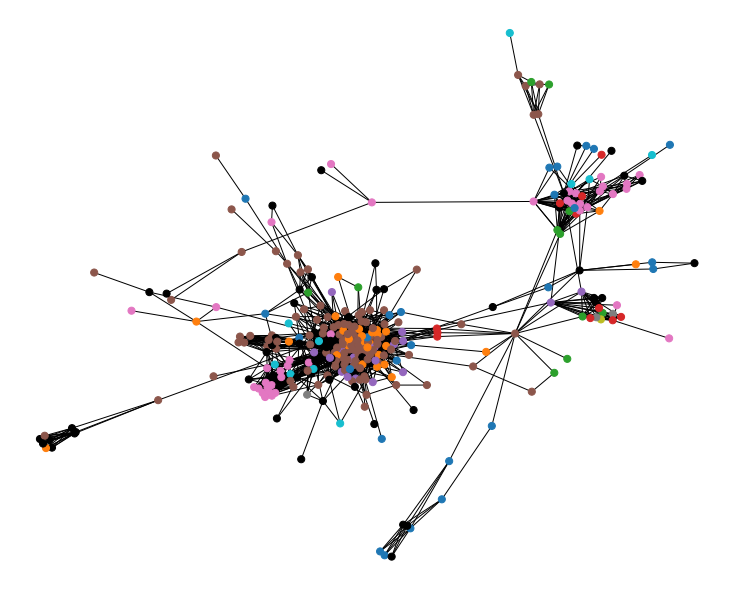

In [55]:
plt.figure(figsize=(10,8))
nx.draw_spring(largest_component,node_size=50,
               nodelist=largest_component.nodes(),
               node_color=node_colors,
               )

Also can be seen by drawing the entire graph:

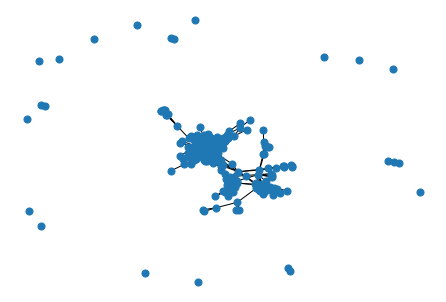

In [300]:
nx.draw_spring(G,node_size=50)
plt.show()

## Finding communities

Looking for communities in the graph.  

See the `using_networkx` notebook for more on `networkx` community discovery tools.

Here we use a fast algorithm that doesn't  always provide the best performance.
We can think of the `partitions` returned as the algorithm's guess at what
the ego network's circles are.

In [345]:
from networkx.algorithms.community import modularity_max
partitions0 = modularity_max.greedy_modularity_communities(largest_component)
partitions = [sorted(list(p)) for p in partitions0]
partition_dict = dict((n,i) for (i,p) in enumerate(partitions) for n in p)

There are many other options.  See [the Scikit learn tutorial on
clusterer evaluation.](https://www.tutorialspoint.com/scikit_learn/scikit_learn_clustering_performance_evaluation.htm)

##### Evaluation

We'd like to evaluate the performance of the community discovery algorithm
with regard to capturing the circles.

The problem is that the algorithm produces a partition of the graph
and the circles are not a partition because a member may belong
to more than one circle.  Thus a measure that can only compare two
partitionings, predicted and true, is not appropriate. Purity
is an example of such a measure.

An alternative is Fowlkes-Mallows Score which can be formulated
as a pair-by-pair comparison:

$$
FMS=\frac{TP}{\sqrt{(TP+FP)(TP+FN)}}
$$

TP = True Positive − number of pair of points belonging to the same clusters in true as well as predicted labels both.

FP = False Positive − number of pair of points belonging to the same clusters in true labels but not in the predicted labels.

FN = False Negative − number of pair of points belonging to the same clusters in the predicted labels but not in the true labels.

To use this idea on circles we define a function that returns True
for a pair of members if there is any overlap in their circles.  
We store the results of applying that function in
a dictionary whose keys are member pairs.

Fowlkes, Edward B; Mallows, Colin L (1983). "A method for comparing two hierarchical clusterings". *Journal of the American Statistical Association*. **78** (383): 553–569. [doi:10.1080/01621459.1983.10478008.](doi:10.1080/01621459.1983.10478008)

In [363]:
import numpy as np

def same_circle (G0, m1,m2):
    def get_circles(m):
        return G0.nodes[m].get('circles',())
    return set(get_circles(m1)).intersection(get_circles(m2))

def fowlkes_mallows_score (G0,partition_dict):
    nodelist = list(G0.nodes())
    tp,fp,fn = 0,0,0
    for (i,m1) in enumerate(nodelist):
        for m2 in nodelist[i+1:]:
            same_partition = (partition_dict[m1]==partition_dict[m2])
            same_c = same_circle(G0,m1,m2)
            if same_partition and same_c:
                tp += 1
            elif same_partition:
                fp += 1
            elif same_c:
                fn += 1
    
    return (tp/np.sqrt((tp+fp)*(tp+fn)))
    

fowlkes_mallows_score (largest_component, partition_dict)

0.3683158297904581

Appendix:  How purity misbehaves.  We get a purity score below the
minimum (.5).

In [344]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    CM = metrics.cluster.contingency_matrix(y_true, y_pred)
    # np.amax(... axis=0) returns the max in each column
    # i.e. the number of members in each cluster belonging
    # to the best represented community.
    return np.sum(np.amax(CM, axis=0)) / np.sum(CM) 

y_pred = [partition_dict[n] for n in largest_component.nodes()]
largest_cc_circlelist = [[m for m in c if m in largest_component.nodes()]
                          for c in circlelist]
print(len(largest_component.nodes()), len(y_pred),
      sum(len(c) for c in largest_cc_circlelist),
      sum(len(p) for p in partitions))

circled_mems = [m for c in largest_cc_circlelist for m in c]
# Not all members have a circle,  Those that do often belong to several
print(len(circled_mems),len(set(circled_mems)))
# Create a new circle for the uncircled mems
uncircled_mems = [m for m in largest_component.nodes() if m not in circled_mems]
largest_cc_circlelist.append(uncircled_mems)
print(sum(len(c) for c in largest_cc_circlelist))
circle_dict = dict((n,i) for (i,p) in enumerate(largest_cc_circlelist) for n in p)
y_true = [circle_dict[n] for n in largest_component.nodes()]

print(f'Purity score: {purity_score(y_true, y_pred):.3f}')

324 324 306 324
306 268
362
Purity score: 0.466


## Finding the average similarity in a circle

Let's find average pairwise similarity of people in a circle.  Look at circle 0:

In [25]:
len(circlelist[0])

20

In [307]:
node_info_dict = G.nodes
sim_scores = [dice_coefficient(node_info_dict[m1], node_info_dict[m2]) 
                for m1 in circlelist[0] 
                  for m2 in circlelist[0]]

#sim_scores = []
#for m1 in circlelist[0]:
#    for m2 in circlelist[0]:
#        #print(m1,node_info_dict[m1])
#        #print(m2, node_info_dict[m2])
#        #print()
#        sim_scores.append(dice_coefficient(node_info_dict[m1], node_info_dict[m2]))
    

In [308]:
print(len(sim_scores))
print(sim_scores[:22])

400
[1.0, 0.17647058823529413, 0.2, 0.125, 0.043478260869565216, 0.14285714285714285, 0.08695652173913043, 0.13333333333333333, 0.21052631578947367, 0.14285714285714285, 0.14285714285714285, 0.045454545454545456, 0.14285714285714285, 0.14285714285714285, 0.15, 0.14285714285714285, 0.041666666666666664, 0.1, 0.1111111111111111, 0.041666666666666664, 0.17647058823529413, 1.0]


Notice the first and last scores printed out are 1.0.  This is because every 21 pairs we take the similarity of a member to themselves, which is always 1.0 by definition.  Obviously, it's not very meaningful to include this case, so we eliminate it:

In [309]:
node_info_dict = G.nodes
sim_scores2 = [dice_coefficient(node_info_dict[m1], node_info_dict[m2]) 
                 for m1 in circlelist[0] 
                    for m2 in circlelist[0] if m1 != m2]
    

In [310]:
print(len(sim_scores2))
print(sim_scores2[:22])

380
[0.17647058823529413, 0.2, 0.125, 0.043478260869565216, 0.14285714285714285, 0.08695652173913043, 0.13333333333333333, 0.21052631578947367, 0.14285714285714285, 0.14285714285714285, 0.045454545454545456, 0.14285714285714285, 0.14285714285714285, 0.15, 0.14285714285714285, 0.041666666666666664, 0.1, 0.1111111111111111, 0.041666666666666664, 0.17647058823529413, 0.2, 0.2]


What we're interested in is the average sim_score:

In [297]:
avg_sim_score = sum(sim_scores)/len(sim_scores)
avg_sim_score

0.2219662575117638

So now we have the knowledge to write a function:

In [311]:
node_info_dict = G.nodes

def get_avg_sim_score(circle):
    sim_scores = [dice_coefficient(node_info_dict[m1], node_info_dict[m2]) 
                    for m1 in circle 
                      for m2 in circle if m1 != m2]
    if sim_scores:
       return sum(sim_scores)/len(sim_scores)
    else:
        return 0.0

The clause which returns 0 is there because there may be circles of length 1, which would give us a `sim_scores` list of length 0.

Now that we have a function it's easy to write a piece of code that computes the average group similarity for all circles.  Let's store it in a dictionary, sort the results,
and print them, along with size of the circle

In [312]:
#get_avg_sim_score(circlelist[0])
for m in circlelist[0]:
    print(items2tuple(node_info_dict[m].items()))

(('education;type', (53, 54)), ('education;year;id', (60, 65)), ('gender', (78,)), ('languages;id', (91, 92, 98)), ('last_name', (118,)), ('locale', (127,)), ('location;id', (133,)), ('work;employer;id', (156,)), ('work;end_date', (165, 173)), ('work;location;id', (181,)), ('work;position;id', (200,)), ('work;start_date', (202, 207, 220)), ('circles', (0,)))
(('education;concentration;id', (14,)), ('education;type', (54,)), ('gender', (78,)), ('locale', (127,)), ('work;employer;id', (152,)), ('work;end_date', (160,)), ('circles', (0,)))
(('gender', (78,)), ('languages;id', (92, 100)), ('locale', (127,)), ('location;id', (133,)), ('circles', (0, 11)))
(('education;type', (53,)), ('education;year;id', (68,)), ('gender', (77,)), ('locale', (127,)), ('circles', (0,)))
(('birthday', (6,)), ('education;type', (53,)), ('education;year;id', (69,)), ('gender', (77,)), ('locale', (127,)), ('work;employer;id', (158,)), ('work;end_date', (173,)), ('work;location;id', (185,)), ('work;position;id', 

In [243]:
circle_sims = dict()
for (i,c) in enumerate(circlelist):
    sim_score = get_avg_sim_score(c)
    circle_sims[i] = sim_score
sorted_circle_sims = sorted(circle_sims.items(),key=lambda x:x[1],reverse=True)
for (i,sim_score) in sorted_circle_sims:
    print('{0:<2}  {1:.3f}  {2:<3}'.format(i,sim_score,len(circlelist[i])))

## Make this a function that can use different ranking functions
def score_and_rank_circles(scoring_func):
    circle_sims = dict()
    for (i,c) in enumerate(circlelist):
       sim_score = scoring_func(c)
       circle_sims[i] = sim_score
    sorted_circle_sims = sorted(circle_sims.items(),key=lambda x:x[1],reverse=True)
    for (i,sim_score) in sorted_circle_sims:
        print ('{0:<2}  {1:.3f}  {2:<3}'.format(i,sim_score,len(circlelist[i])))
    return circle_sims

7   0.500  2  
23  0.435  3  
20  0.356  6  
13  0.351  5  
2   0.318  9  
14  0.312  2  
10  0.306  4  
19  0.290  13 
6   0.254  20 
9   0.253  10 
3   0.232  3  
4   0.219  17 
15  0.215  133
11  0.210  30 
17  0.202  9  
0   0.181  20 
16  0.174  32 
1   0.000  1  
5   0.000  1  
8   0.000  1  
12  0.000  1  
18  0.000  1  
21  0.000  1  
22  0.000  1  


Note that group 2, has both a fairly high average sim score and significant size.  So it's interesting.  Note also that the largest group by far (over half of ego's friends) has significant internal similarity.  Next let's find out which group has the greatest similarity to ego. The code is very simailar.

In [313]:
node_info_dict = G.nodes

def get_avg_ego_sim(circle):
    sim_scores = [dice_coefficient(node_info_dict[m1], ego_feat_dict) for m1 in circle]
    return sum(sim_scores)/len(sim_scores)
                  
## Make the code above a function that can use different ranking functions
def score_and_rank_circles(circlelist, scoring_func):
    circle_sims = dict()
    for (i,c) in enumerate(circlelist):
       sim_score = scoring_func(c)
       circle_sims[i] = sim_score
    sorted_circle_sims = sorted(circle_sims.items(),key=lambda x:x[1],reverse=True)
    for (i,sim_score) in sorted_circle_sims:
        print ('{0:<2}  {1:.3f}  {2:<3}'.format(i,sim_score,len(circlelist[i])))
                  
ego_sim_rankings = score_and_rank_circles(circlelist, get_avg_ego_sim)

7   0.144  2  
1   0.136  1  
22  0.118  1  
19  0.117  13 
14  0.117  2  
16  0.109  32 
10  0.108  4  
20  0.107  6  
6   0.105  20 
9   0.105  10 
4   0.102  17 
15  0.100  133
11  0.096  30 
13  0.089  5  
12  0.087  1  
0   0.079  20 
17  0.076  9  
2   0.068  9  
8   0.059  1  
23  0.056  3  
21  0.056  1  
5   0.050  1  
18  0.048  1  
3   0.013  3  


So circle 13 looks interesting, because it has size and significant similarity to ego.

Lets pass `get_avg_ego_sim` a "circle" consisting of all of ego's friends.

In [248]:
get_avg_ego_sim(node_info_dict.keys())

0.0994593191404611

Here we've used `G.node`, the dictionary that contains all the friend attribute dictionaries, and of course the list of its keys (`G.node.keys()`) is the list of all friends.  And we see something interesting.  The average pairwise similarity of friends at large is much smaller than the average similarity of people within circles.  It's too soon to tell, of course, but maybe people **do** tend to travel within circles of people who are similar to them.